# Chapter 06
- Loss function의 값을 통해 가중치를 업데이트하는 법을 배워본다.
- Loss function을 미분한 값의 의미를 알아본다.
- 배운 내용들을 토대로 구현을 통해 실제 학습을 진행하여 본다.

## 1. 미분
<img src="./images/differentiate.jpg" alt="Neural" style="height: 300px;"/>
- 미분 => 함수의 움직임을 파악하는데 효과적인 방법
- 수치미분, 편미분의 내용은 생략
- 미분을 통해 나온 기울기 값으로 가중치 업데이트를 진행한다.


In [1]:
import numpy as np

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        
        tmp_val = x[idx]
        
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = float(tmp_val) - h 
        fxh2 = f(x) # f(x-h)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad

## 2. 경사하강법
- Loss function의 값에 영향을 주는 값 : 가중치 W
- Loss function의 값 -> 오차의 크기
- Loss function의 값을 최소화 시키자.
- Loss function의 미분값이 0이되는 최솟값을 찾아보자.
<img src="./images/gradient_descent.png" alt="Neural" style="height: 250px;"/>
- 경사법의 수식
<img src="./images/learning_rate.png" alt="Neural" style="height: 150px;"/>

### 학습률 ( Learning rate)
- 한번의 반복당 얼마만큼 반영을 시킬 것인가의 비율
- 너무 작은 경우 학습 속도가 너무 느리다.
- 너무 큰 경우 가중치가 그래프 상에서 튀어다니거나 발산한다.
- 적절한 학습률을 찾아내는 것도 중요하다.
- hyperparameter : 사람이 직접 설정해주는 매개변수. Hyperparameter의 최적화 알고리즘도 존재한다.


In [2]:
def gradient_descent(f, init_w, lr=0.01, step_num = 100):
    w = init_w
    
    for i in range(step_num):
        grad = numerical_gradient(f,w)
        w -= lr * grad
        
    return w

### 학습에 따른 가중치 변화실험

In [3]:
from functions import * # functions 이전에 구현했던 함수들을 모아논 파일

In [4]:
class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # 2x3 행렬을 정규분포로 초기화

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z) # Activation function at output layer
        loss = cross_entropy_error_general(y, t) # Loss function

        return loss

x = np.array([0.6, 0.9])
t = np.array([0, 0, 1])

net = simpleNet()
print(net.W) # 학습 전 가중치 매개변수 확인
print("--------------")

f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W) # 학습 전 Loss function의 기울기 값 확인
print(dW)
print("--------------")

newW = gradient_descent(f,net.W) # 학습 후 업데이트된 가중치 값 확인
print(newW)

[[-1.47201734  1.52716945  1.86343647]
 [ 0.25469807 -0.35800857 -1.59637434]]
--------------
[[ 0.10200601  0.35535162 -0.45735763]
 [ 0.15300901  0.53302744 -0.68603645]]
--------------
[[-1.56862307  1.24803553  2.23917611]
 [ 0.10978948 -0.77670945 -1.03276487]]


***학습을 통해 찾아낸 가중치가 완벽한 최솟값이라는 보장이 없다. 왜냐하면 극솟값이거나 안장점일 수도 있기 때문***

## 3. 미니배치 2층 신경망 클래스 구현하기
1. 미니배치
2. 기울기 산출
3. 매개변수 갱신
4. 1~3 단계 반복

### 1) 모델 만들기

In [5]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size) # 1층의 가중치
        self.params['b1'] = np.zeros(hidden_size) # 1층의 편향
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) # 2층의 가중치
        self.params['b2'] = np.zeros(output_size) # 2층의 편향

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error_general(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient_complex(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1']) # 위에서 구현한 수치미분
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t): # 오차역전파 방식. 우리는 배우지 않았습니다.
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

### 2) 학습 구현 및 테스트 해보기

train acc, test acc | 0.09313333333333333, 0.0957
train acc, test acc | 0.79235, 0.7951
train acc, test acc | 0.8794666666666666, 0.8816
train acc, test acc | 0.89955, 0.9018
train acc, test acc | 0.9087333333333333, 0.9127
train acc, test acc | 0.91495, 0.917
train acc, test acc | 0.9195, 0.9215
train acc, test acc | 0.9237166666666666, 0.9259
train acc, test acc | 0.92725, 0.9282
train acc, test acc | 0.9312666666666667, 0.9321
train acc, test acc | 0.93345, 0.9336
train acc, test acc | 0.936, 0.9372
train acc, test acc | 0.9391833333333334, 0.94
train acc, test acc | 0.9417166666666666, 0.9411
train acc, test acc | 0.9436666666666667, 0.9421
train acc, test acc | 0.9454833333333333, 0.9441
train acc, test acc | 0.9472166666666667, 0.9472
train acc, test acc | 0.9488166666666666, 0.9481
train acc, test acc | 0.9501, 0.9492
train acc, test acc | 0.9515, 0.9494
train acc, test acc | 0.9532833333333334, 0.9504
train acc, test acc | 0.9538, 0.951
train acc, test acc | 0.9557833333333333,

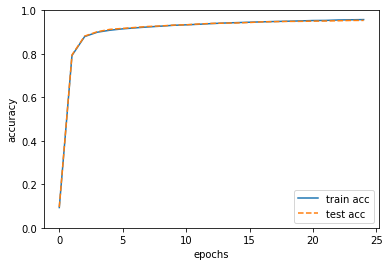

In [7]:
import import_ipynb
import matplotlib.pylab as plt
from mnist import load_mnist
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 15000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
#     grad = network.numerical_gradient_complex(x_batch, t_batch) # 엄청 오래걸려요.
    grad = network.gradient(x_batch, t_batch) # 우리는 대신 이것으로 맛보기 합니다.
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

***여러분은 기본적인 머신러닝 학습법을 익혀보고 인공신경망을 구축해 보았습니다.***